# End-to-end DSPy Workflows Guide 

Time to complete: X Hours

## Problem

You are a bank, and you want to categorize customer support queries into one of 25 categories. You have hand labeled 100 examples and have collected 4,000 unlabeled examples.

You want to use an LLM to solve this problem, because you don't have enough labeled data to train a traditional classifier.

You also don't want to spend a lot of money on inference. 

## Motivation

You decide to use DSPy to solve this problem because the following flow is fairly difficult to orchestrate manually:
Data Collection/Labeling -> Fine-tuning -> Prompt Optimization -> Evaluation -> Deployment

By using DSPy on Anyscale, you can easily orchestrate this flow and solve the problem.

## Solution

You don't want pay to host a 70B model, so you will instead finetune a 1B model, which you can host and serve at a low cost using Anyscale's RayLLM offering.

In order to help the 1B model understand the reasoning behind why the 70B model makes certain classifications, you will use Chains of Thought to distill knowledge from the 70B model.

So what will this look like?

1. Collect 4,000 unlabeled examples
2. Label all of them with your 70B oracle model running locally
3. Use the new DSPy finetuning tools to finetune a 1B model
- This takes about 20 minutes on 4xA100-80GB GPUs, and uses Anyscale's LLMForge in the background to finetune the model
4. Evaluate and prompt optimize your 1B model checkpoints against the labeled dataset
5. Take the best performing 1B checkpoint and compare it to the un-finetuned 1B model on the true test set
6. Deploy the optimized 1B model/DSPy pipeline to production using Anyscale's RayLLM # TODO

Note(isaac): we arent doing anything with the 100 labeled examples yet

# Table of Contents

## Set Up
1. Installing DSPy
2. Setting up the environment
3. Loading the dataset
4. Setting up the program, metric, and evaluator

## Data Collection

1. Collect 4,000 unlabeled examples
2. Label all of them with your 70B oracle model running locally

## Fine-tuning

1. Use the new DSPy finetuning tools to finetune a 1B model
- This takes about 20 minutes on 4xA100-80GB GPUs, and uses Anyscale's LLMForge in the background to finetune the model

## Evaluation
1. Evaluate and prompt optimize your 1B model checkpoints against the labeled dataset
2. Find the best performing 1B checkpoint and compare it to the un-finetuned 1B model on the true test set

## Serving
1. Deploy the optimized 1B model/DSPy pipeline to production using Anyscale's RayLLM # TODO

## Future Work and Open Questions
- Efficient batch inference with a DSPy pipeline
- Exploring different fine-tuning methods and hyperparameter sweeps

This guide aims to provide a comprehensive overview of building, optimizing, and deploying LLM pipelines using DSPy and Anyscale.

## Set up

Node Set up:

We will be running everything on a head node that uses 4xA100-80GB GPUs. I find that L4s are usually available and suitable for this usecase. You can also use any more powerful node.

To change to use A100 GPUs, click the "1 active node" in the top right corner, then for workspace node, click the pencil icon and navigate to the A100 tab and select the 4xA100 option. If you do not see A100 in the list of GPUs, they may not be available on your cloud.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib.util

if importlib.util.find_spec("dspy") is None:
    print("Installing dspy")
    !git clone -b dev_finetune https://github.com/stanfordnlp/dspy.git
    !cd dspy && pip install -e .
else:
    print("dspy is already installed")

# !pip install -e dspy

dspy is already installed


In [3]:
import dspy
dspy.settings.configure(experimental=True)

import ujson

from dotenv import load_dotenv
load_dotenv()

from src import set_dspy_cache_location
set_dspy_cache_location("/home/ray/default/dspy/cache")

In order to run this notebook, you need to have the following environment variables set:
- HF_TOKEN
- HF_HOME=/mnt/local_storage/huggingface
- (optional) WANDB_API_KEY

You can get a HF_TOKEN [here](https://huggingface.co/settings/tokens).

You can get a WANDB_API_KEY [here](https://wandb.ai/authorize).

In [4]:
from src import check_env_vars
check_env_vars()

In [5]:
from src import init_ray
init_ray()

2024-10-17 00:04:22,792	INFO worker.py:1601 -- Connecting to existing Ray cluster at address: 10.0.15.228:6379...
2024-10-17 00:04:22,801	INFO worker.py:1777 -- Connected to Ray cluster. View the dashboard at https://session-fkvdirx4bzefi53sjl55m7asad.i.anyscaleuserdata.com 
2024-10-17 00:04:22,828	INFO packaging.py:531 -- Creating a file package for local directory '/home/ray/default/dspy-1/dspy'.
2024-10-17 00:04:22,861	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_60d0ad1165de7e97.zip' (0.99MiB) to Ray cluster...
2024-10-17 00:04:22,874	INFO packaging.py:372 -- Successfully pushed file package 'gcs://_ray_pkg_60d0ad1165de7e97.zip'.
2024-10-17 00:04:22,891	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_d05820e7c6dcb20401954662cf7c7d09712b3a9d.zip' (2.90MiB) to Ray cluster...
2024-10-17 00:04:22,919	INFO packaging.py:372 -- Successfully pushed file package 'gcs://_ray_pkg_d05820e7c6dcb20401954662cf7c7d09712b3a9d.zip'.


We will make use of a random number generator in this notebook. We are creating a Random object here to ensure that our notebook is reproducible.

In [6]:
from src import set_random_seed
rng = set_random_seed()

We will be using the PolyAI/banking77 dataset for this tutorial. We use the built in dspy DataLoader to load the dataset from Huggingface as a list of dspy.Example objects.

In [7]:
%%capture
# Prepare the dataset
from src import load_data_from_huggingface
full_trainset, full_testset = load_data_from_huggingface()

In [8]:
from src import preprocess_data
full_trainset_processed, full_testset_processed = preprocess_data(full_trainset, full_testset)

print("Example training set: ", full_trainset_processed[0])

Example training set:  Example({'label': 'card_arrival', 'text': 'I am still waiting on my card?'}) (input_keys={'text'})


The dataset is originally called "banking77" because there are 77 labels. We will be reducing this to the top 25 most frequent labels.

In [9]:
from src import filter_to_top_n_labels
full_trainset_filtered, full_testset_filtered, top_25_labels = filter_to_top_n_labels(full_trainset_processed, full_testset_processed, n=25)

print(f"Dataset filtered to top 25 labels. New sizes:")
print(f"Training set size: {len(full_trainset_filtered)}; Test set size: {len(full_testset_filtered)}")
print(f"Top 25 labels: {', '.join(str(label) for label in top_25_labels)}")
print(f"Example training set: {full_trainset_filtered[0]}")
print(f"Example test set: {full_testset_filtered[0]}")


Dataset filtered to top 25 labels. New sizes:
Training set size: 4171; Test set size: 1000
Top 25 labels: card_payment_fee_charged, direct_debit_payment_not_recognised, balance_not_updated_after_cheque_or_cash_deposit, wrong_amount_of_cash_received, cash_withdrawal_charge, transaction_charged_twice, declined_cash_withdrawal, transfer_fee_charged, balance_not_updated_after_bank_transfer, transfer_not_received_by_recipient, request_refund, card_payment_not_recognised, card_payment_wrong_exchange_rate, extra_charge_on_statement, wrong_exchange_rate_for_cash_withdrawal, refund_not_showing_up, reverted_card_payment, cash_withdrawal_not_recognised, activate_my_card, pending_card_payment, cancel_transfer, beneficiary_not_allowed, card_arrival, declined_card_payment, pending_top_up
Example training set: Example({'label': 'card_arrival', 'text': 'I am still waiting on my card?'}) (input_keys={'text'})
Example test set: Example({'label': 'card_arrival', 'text': 'How do I locate my card?'}) (inpu

We need to pass the labels to the LLM somehow.

In DSPy, we can do this by either including it in the docstring of the program or by adding it as an input field to the Signature.

Here, we will add it to the docstring, because the set of labels is fixed.

In [10]:
labels_in_use = top_25_labels
print(labels_in_use)

['card_payment_fee_charged', 'direct_debit_payment_not_recognised', 'balance_not_updated_after_cheque_or_cash_deposit', 'wrong_amount_of_cash_received', 'cash_withdrawal_charge', 'transaction_charged_twice', 'declined_cash_withdrawal', 'transfer_fee_charged', 'balance_not_updated_after_bank_transfer', 'transfer_not_received_by_recipient', 'request_refund', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'extra_charge_on_statement', 'wrong_exchange_rate_for_cash_withdrawal', 'refund_not_showing_up', 'reverted_card_payment', 'cash_withdrawal_not_recognised', 'activate_my_card', 'pending_card_payment', 'cancel_transfer', 'beneficiary_not_allowed', 'card_arrival', 'declined_card_payment', 'pending_top_up']


Now we will shuffle our training set and split it into a training and labeled set.

The scenario we are emulating is that we only have 100 labeled examples to train on. We are saying that we have 4K (length of the training set) unlabeled examples we can then label using an oracle model, and then distill the knowledge from the oracle model into our 1B model.

In [11]:
from src import common_kwargs

shuffled_trainset = [d for d in full_trainset_filtered]
rng.shuffle(shuffled_trainset)

# The devset shouldn't overlap
ft_trainset = shuffled_trainset[:-100]
labeled_trainset = shuffled_trainset[-100:]

testset = full_testset_filtered
evaluate_testset = dspy.Evaluate(devset=testset, **common_kwargs)

This is a simple, 1 step Chain of Thought program.

In DSPy, you define a Signature to show your inputs and outputs. You define a module to run the different steps of your program.

Our signature has a note at the top containing a simple prompt along with the list of valid outputs.

We then have an `intent` field which is the input to the program.

Finally we have a `label` field which is the output of the program.

We give both of these fields a short description.

In [12]:
# We are setting the experimental flag to True to make use of the fine-tuning
# features that are still in development.
dspy.settings.configure(experimental=True)
import inspect
from src import IntentClassification, IntentClassificationModule

print(inspect.getsource(IntentClassification))

class IntentClassification(dspy.Signature):
    """As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
    The intent should exactly match one of the following:
    ['card_payment_fee_charged', 'direct_debit_payment_not_recognised', 'balance_not_updated_after_cheque_or_cash_deposit', 'wrong_amount_of_cash_received', 'cash_withdrawal_charge', 'transaction_charged_twice', 'declined_cash_withdrawal', 'transfer_fee_charged', 'balance_not_updated_after_bank_transfer', 'transfer_not_received_by_recipient', 'request_refund', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'extra_charge_on_statement', 'wrong_exchange_rate_for_cash_withdrawal', 'refund_not_showing_up', 'reverted_card_payment', 'cash_withdrawal_not_recognised', 'activate_my_card', 'pending_card_payment', 'cancel_transfer', 'beneficiary_not_allowed', 'card_arrival', 'declined_card_payment', 'pending_top_up']
    """

    intent = dspy.InputFie

For the module, we create a dspy.Module class that contains the Chain of Thought predictor using the signature we defined above.
We also pass in the valid labels to the module.

Inside the forward method, we pass the text to the predictor, do a little cleaning, and return the prediction.

In [13]:
print(inspect.getsource(IntentClassificationModule))

class IntentClassificationModule(dspy.Module):
    def __init__(self, labels_in_use):
        self.intent_classifier = dspy.ChainOfThought(IntentClassification)
        self.valid_labels = set(labels_in_use)

    def forward(self, text):
        prediction = self.intent_classifier(intent=text)
        sanitized_prediction = dspy.Prediction(label=prediction.label.lower().strip().replace(" ", "_"), reasoning=prediction.reasoning)
        return sanitized_prediction



Lastly, we set up some the vanilla program we will use throughout the notebook.

In [14]:
from src import MODEL_PARAMETERS, LOCAL_API_PARAMETERS
vanilla_program = IntentClassificationModule(labels_in_use)

In [15]:
# Note: Run above this to do all setup without launching any models
# This is useful if you have already collected data and want to start from finetuning or from evaluation

We will be using a local VLLM instance to run the initial benchmarks and data collection.

# Gathering training data and running the 70B Model


## Preparation

Before running the 70B model:
1. Remember to set your HF_TOKEN and HF_HOME environment variables
2. Use the following command to start the 70B server:

   ```
   vllm serve meta-llama/Meta-Llama-3.1-70B-Instruct --port 8000 --pipeline_parallel_size 2 --enable_prefix_caching --tensor_parallel_size 2
   ```

## Parallelism Configuration

We've chosen pipeline parallelism and tensor parallelism of 2 for the 70B model based on our current setup. Here's the reasoning:

1. Model size: The 70B model has 30 parts of ~5 GB each (based on [HuggingFace documentation](https://huggingface.co/meta-llama/Meta-Llama-3.1-70B-Instruct/tree/main)).
   - Total size: 30 * 5 GB = 150 GB

2. Available VRAM:
   - Our GPUs: 80 GB VRAM x 4 = 320 GB
   - Tensor parallelism: floor(320/150) = 2
   - Pipeline parallelism: floor(num_gpus/2) = 2
   - To use all 4 GPUs efficiently:
     - Pipeline parallel size: 2
     - Tensor parallelism: 2

3. Alternative setup (8x24GB GPUs):
   - Pipeline parallel size: 1
   - Tensor parallelism: ceil(150/24) = 7

This configuration allows us to run the 70B model efficiently across our available GPU resources.

Note that on Anyscale, you CANNOT download a 70B model without changing HF_HOME on most machines. The folder `/mnt/local_storage/' has enough space for a model download. It is not persisted across cluster restarts, but that is fine for model weights we don't need to save.

In [16]:
# Command for easy copying: 
# `export HF_HOME=/mnt/local_storage/huggingface; vllm serve meta-llama/Meta-Llama-3.1-70B-Instruct --port 8000 --pipeline_parallel_size 2 --enable_prefix_caching --tensor_parallel_size 2`
input("Press Enter once you have the vllm server running...")

''

In [17]:
llama_70b = dspy.LM(model="openai/meta-llama/Meta-Llama-3.1-70B-Instruct", **MODEL_PARAMETERS, **LOCAL_API_PARAMETERS)

In [18]:
from src import sanity_check_program

sanity_check_program(llama_70b, vanilla_program, ft_trainset[0])

Program input: Example({'label': 'extra_charge_on_statement', 'text': 'I still have not received an answer as to why I was charged $1.00 in a transaction?'}) (input_keys={'text'})
Program output label: extra_charge_on_statement


### Bootstrap Data


In this section, we bootstrap data for fine-tuning. In the code block below, we are deciding which program should be used to collect the bootstraps. We are setting this to the prompt optimized program, but one could also set this to the vanilla program, though doing so would lead to lower quality bootstraps.

In [19]:
from dspy.teleprompt.finetune_teleprompter import bootstrap_data, convert_to_module_level_message_data
from src import delete_labels, NUM_THREADS, write_jsonl
from src.data_preprocess import valid_label_metric

# For realism of this scenario, we are going to delete all our labels except for our test set(which is cheating and we wouldn't have in production) and our 100 true labeled examples
ft_trainset_to_label = delete_labels(ft_trainset)


with dspy.context(lm=llama_70b):
    collected_data = bootstrap_data(vanilla_program, ft_trainset_to_label, num_threads=NUM_THREADS, max_errors=10000, metric=valid_label_metric)
    # Make sure to only include the labels we are actively using or that arent hallucinated by the oracle
    collected_data_filtered = [x for x in collected_data if x["prediction"]["label"] in labels_in_use]
    
    dataset = convert_to_module_level_message_data(collected_data_filtered, program=vanilla_program, exclude_demos=True)

    dataset_formatted = [{"messages": item} for item in dataset]

print(dataset[0])
print(len(dataset))

Average Metric: 4067 / 4071  (99.9): 100%|██████████| 4071/4071 [00:03<00:00, 1081.96it/s] 


[{'role': 'system', 'content': "Your input fields are:\n1. `intent` (str): Intent of the query\n\nYour output fields are:\n1. `reasoning` (str): ${produce the output fields}. We ...\n2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text\n\nAll interactions will be structured in the following way, with the appropriate values filled in.\n\n[[ ## intent ## ]]\n{intent}\n\n[[ ## reasoning ## ]]\n{reasoning}\n\n[[ ## label ## ]]\n{label}\n\n[[ ## completed ## ]]\n\nIn adhering to this structure, your objective is: \n        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.\n        The intent should exactly match one of the following:\n        ['card_payment_fee_charged', 'direct_debit_payment_not_recognised', 'balance_not_updated_after_cheque_or_cash_deposit', 'wrong_amount_of_cash_received', 'cash_withdrawal_charge', 'transaction_charged_twice', 'declined_cash_withdrawal', 'transf

In [20]:
# Nice utility to save the data in case you do not run the notebook all the way through
if True:
    with open("collected_data_filtered.jsonl", "w") as f:
        for item in collected_data_filtered:
            f.write(ujson.dumps({"example": item["example"], "prediction": item["prediction"]}) + "\n")
else:
    with open("collected_data_filtered.jsonl", "r") as f:
        collected_data_filtered = [ujson.loads(line) for line in f]


# Fine-tuning

We will use LLM Forge to fine-tune the 1B model.

In order to do this, we need to format our data into the correct format (Follows OpenAI messaging format).

We can let DSPy do the rest, where it will properly generate the config and run the finetuning.

Be sure to checkout the fine-tuning documentation for the latest on how to use our [API](https://docs.anyscale.com/llms/finetuning/intro) and additional [capabilities](https://docs.anyscale.com/category/fine-tuning-beta/).

We'll fine-tune our LLM by choosing a set of configurations. We have created recipes for different LLMs in the [`training configs`](configs/training/lora/llama-3-8b.yaml) folder which can be used as is or modified for experiments. These configurations provide flexibility over a broad range of parameters such as model, data paths, compute to use for training, number of training epochs, how often to save checkpoints, padding, loss, etc. We also include several [DeepSpeed](https://github.com/microsoft/DeepSpeed) [configurations](configs/deepspeed/zero_3_offload_optim+param.json) to choose from for further optimizations around data/model parallelism, mixed precision, checkpointing, etc.

We also have recipes for [LoRA](https://arxiv.org/abs/2106.09685) (where we train a set of small low ranked matrices instead of the original attention and feed forward layers) or full parameter fine-tuning. We recommend starting with LoRA as it's less resource intensive and quicker to train.

In [23]:
from dspy.clients.lm import TrainingMethod
from src import finetuning_kwargs

train_data = dataset_formatted
method = TrainingMethod.SFT

finetuneable_lm = dspy.LM(model="meta-llama/Llama-3.2-1B-Instruct")

try:
    finetuning_job = finetuneable_lm.finetune(method, train_data, eval_data=None, provider="anyscale", train_kwargs=finetuning_kwargs)
    finetuning_job.result()
    model_names = finetuning_job.model_names
except Exception as e:
    print(e)


Copying file:///home/ray/.dspy_cache/finetune/anyscale_6e332a9ff41cc87d.jsonl to gs://storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e/org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/anyscale_6e332a9ff41cc87d.jsonl
  
.
(anyscale +5m1.4s) Uploading local dir '.' to cloud storage.
(anyscale +5m4.0s) Job 'dspy-llmforge-fine-tuning-job' submitted, ID: 'prodjob_vmqx9yv5alunb2s68prunjbg8z'.
(anyscale +5m4.0s) View the job in the UI: https://console.anyscale.com/jobs/prodjob_vmqx9yv5alunb2s68prunjbg8z
(anyscale +5m4.2s) Waiting for job 'prodjob_vmqx9yv5alunb2s68prunjbg8z' to reach target state SUCCEEDED, currently in state: STARTING
(anyscale +10m24.2s) Job 'prodjob_vmqx9yv5alunb2s68prunjbg8z' transitioned from STARTING to RUNNING
(anyscale +20m30.4s) Job 'prodjob_vmqx9yv5alunb2s68prunjbg8z' transitioned from RUNNING to SUCCEEDED
(anyscale +20m30.4s) Job 'prodjob_vmqx9yv5alunb2s68prunjbg8z' reached target state, exiting


# Evaluation

## Performance comparisons

Synthetic Devset:
- 1B Non-finetuned
- 1B Non-finetuned + Prompt Optimization
- 1B Finetuned (all checkpoints)
- 1B Finetuned (all checkpoints) + Prompt Optimization

Note that for this task, where the eval loss of a checkpoint isn't necessarily informative of the downstream performance of the program, because there are chains of though inside output, we need to test all possible checkpoints to see which one performs best.

In [24]:
print(model_names)

['meta-llama/Llama-3.2-1B-Instruct:epochs-0-total-trained-steps-32', 'meta-llama/Llama-3.2-1B-Instruct:epochs-2-total-trained-steps-96', 'meta-llama/Llama-3.2-1B-Instruct:epochs-5-total-trained-steps-192', 'meta-llama/Llama-3.2-1B-Instruct:epochs-4-total-trained-steps-160', 'meta-llama/Llama-3.2-1B-Instruct:epochs-1-total-trained-steps-64', 'meta-llama/Llama-3.2-1B-Instruct:epochs-3-total-trained-steps-128']


We will run a local RayLLM instance that serves the model.

Provided with this template is are two files, `serve_1B.yaml` and `\model_configs\meta-llama--Llama-3_2-1B-Instruct.yaml`. 

The first file, `serve_1B.yaml`, contains the serve configuration to load the model with RayLLM.

The second file, `\model_configs\meta-llama--Llama-3_2-1B-Instruct.yaml`, contains the necessary configurations to run the 1B model.

The important part of the second file is the "dynamic_lora_loading_path" field. This is the path to the folder where the LoRA weights are stored.

DSPy will automatically save the LoRA weights to a folder in your cloud environment at $ANYSCALE_

Make sure to set your HF_TOKEN and HF_HOME environment variables, and run the following command to start the server:

```bash
serve run serve_1B.yaml
```

In [25]:
from src import update_serve_config_hf_token

update_serve_config_hf_token("serve_1B.yaml")

In [59]:
# Command for easy copying:

# `serve run serve_1B.yaml`
input("Press Enter once you have the RayLLM server running...")

''

In [26]:
from src import get_llama_lms_from_model_names

all_llamas = get_llama_lms_from_model_names(model_names)

In [27]:
# Sanity check that the finetuned models are working

finetuned_llama = list(all_llamas.values())[0]
sanity_check_program(finetuned_llama, vanilla_program, ft_trainset[0])

Program input: Example({'text': 'I still have not received an answer as to why I was charged $1.00 in a transaction?'}) (input_keys={'text'})


Program output label: card_payment_fee_charged


Now let's try optimizing the program with the finetuned model

Now we know how well the base pipeline performs, let's run prompt optimization on the pipeline in order to juice up the performance.

Let's go over what the hyperparameters mean:
- max_bootstrapped_demos: DSPy will "bootstrap" the program by collecting examples at each step that are successful and reusing those in the pipeline. This means that it will automatically collect and add chains of thought to the pipeline.
- max_labeled_demos: DSPy will also insert some labeled demonstrations from the training set. These would be unmodified examples from the training set that are just using the gold answer.
- num_candidate_programs: This is the number of candidate programs that the optimizer will generate. The actual number of programs that are created is this plus three, as DSPy will also try a program with no examples, a program with just the labeled demonstrations, and a bootstrapped program with the first few examples.
- optimizer_num_train and optimizer_num_val: These are the number of examples that the optimizer will use for training and validation. Note that we will be taking the all of these examples from our synthetic devset.

In [28]:
from src import bootstrap_fewshot_random_search_parameters, metric

print("Parameters:")
for k, v in bootstrap_fewshot_random_search_parameters.items():
    print(f"{k}: {v}")

Parameters:
max_bootstrapped_demos: 3
max_labeled_demos: 3
num_candidate_programs: 6


In [29]:
from src import split_into_devset_and_optimizer_sets

def collected_data_to_example(data):
    return dspy.Example(text=data["example"]["text"], label=data["prediction"]["label"]).with_inputs("text")

collected_data_examples = [collected_data_to_example(x) for x in collected_data_filtered]

devset_synthetic, ft_optimizer_trainset, ft_optimizer_devset = split_into_devset_and_optimizer_sets(collected_data_examples, dev_size=1000, optimizer_num_val=300)
print("Lengths:")
print("Synthetic Devset: ", len(devset_synthetic))
print("Optimizer Trainset: ", len(ft_optimizer_trainset))
print("Optimizer Devset: ", len(ft_optimizer_devset))
print("Example from synthetic devset:")
print(devset_synthetic[0])

Lengths:
Synthetic Devset:  1000
Optimizer Trainset:  2765
Optimizer Devset:  300
Example from synthetic devset:
Example({'text': 'I still have not received an answer as to why I was charged $1.00 in a transaction?', 'label': 'extra_charge_on_statement'}) (input_keys={'text'})


In [33]:
%%capture
from src import evaluate_and_prompt_optimize

evaluation_kwargs = {
    "models": all_llamas,
    "program": vanilla_program,
    "optimizer_trainset": ft_optimizer_trainset,
    "optimizer_valset": ft_optimizer_devset,
    "devset": devset_synthetic,
    "metric": metric,
    "labels_in_use": labels_in_use
}

ft_results = evaluate_and_prompt_optimize(**evaluation_kwargs)

In [34]:
if True:
    import json
    with open("ft_results.json", "w") as f:
        json.dump(ft_results, f)
else:
    ft_results = json.load(open("ft_results.json"))

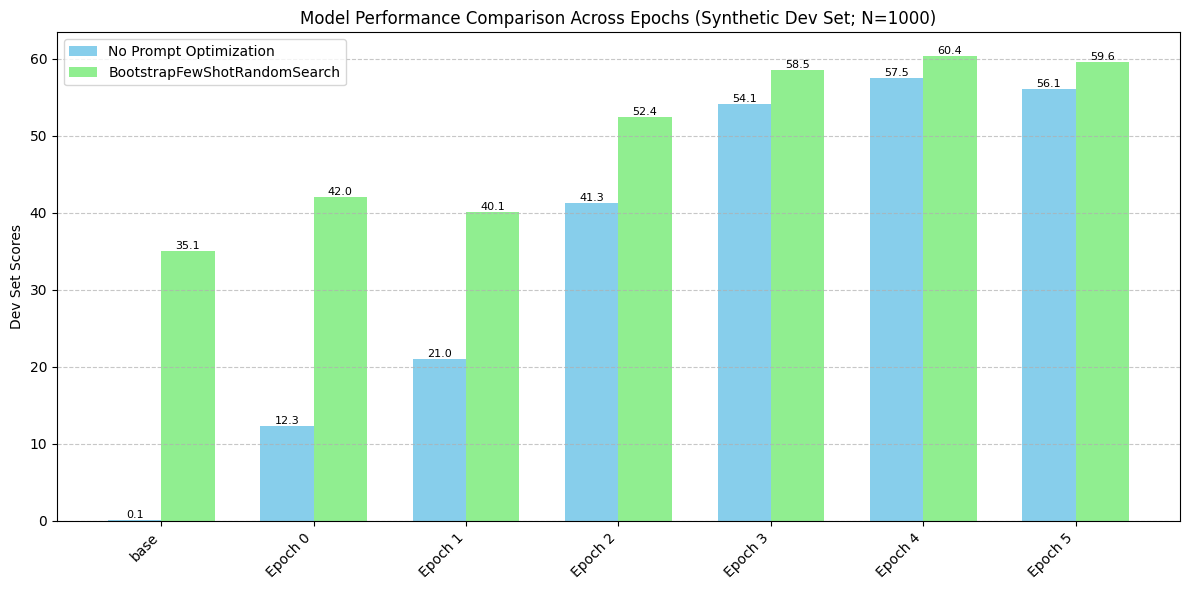

Highest Dev Set Score: 60.4, Model: Epoch 4


In [35]:
from src import graph_devset_results, graph_testset_results

graph_devset_results(ft_results)

We see that the highest performing model is the final epoch with a score of 50.2 on our synthetic devset.

We will now take this best performing model and evaluate it and our prompt optimized base model on the true test set to see if we have improved performance.

In [37]:
%%capture
# Now we need to evaluate the test set
from src import run_testset_evaluation

ft_results_testset = run_testset_evaluation(ft_results, all_llamas, labels_in_use, testset, metric=metric)

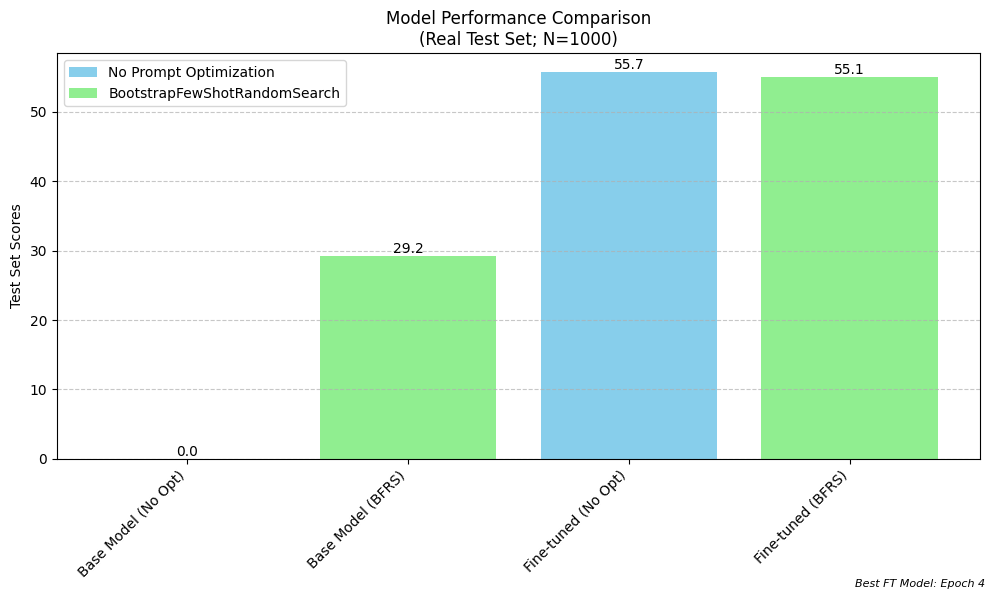

In [40]:
graph_testset_results(ft_results_testset)

# TODO - Serving

We'll start by running the rayllm CLI command below to start the workflow to generate the service yaml configuration:
```bash
mkdir /home/ray/default/deploy/services
cd /home/ray/default/deploy/services
rayllm gen-config 
```

<img src="assets/cli.png" width=500 alt="todo! get this inage of what I need to serve">


<b style="background-color: yellow;">&nbsp;🛑 IMPORTANT&nbsp;</b>: Please `Terminate` your service from the Service page to avoid depleting your free trial credits.

In [ ]:
# Clean up
!python src/clear_cell_nums.py
!find . | grep -E ".ipynb_checkpoints" | xargs rm -rf
!find . | grep -E "(__pycache__|\.pyc|\.pyo)" | xargs rm -rf
!rm -rf __pycache__ data .HF_TOKEN deploy/services